# Lung inflammation v3

This notebook uses the [dataset](https://osf.io/28qbc/) from the publication "[Deep neural network based histological scoring of lung fibrosis and inflammation in the mouse model system](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0202708)" to train an CNN based on a ResNet34 to characterize inflammatory lung diseases from sections of lung tissue.<br><br>

**Publication benchmark:**<br>
Model: Inception V3, pretrained on ImageNet<br>
Accuracy: 0.80 (80%).<br><br>


<font color='blue'>**Notebook results:**<br>
Model: ResNet34, pretrained on ImageNet<br>
Data: training and validation data were used as in the provided dataset<br>
Training: image size of 224 for stage 1 and 2, image size of 512 for stage 3;<br>
stage 1: training of new network head;<br>
stage 2: training of the entire network with discriminative learning rates;<br>
stage 3: training of the entire network<br>
Accuracy: 0.82 (82%).<br><br>
    
**Summary:**<br>In this notebook it could be shown that state-of-the-art results published August 23 2018 could be  improved with a smaller model.

## Notebook setup

In [1]:
## notebook setup
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# import fastai
from fastai import *
from fastai.vision import *

In [3]:
# set path
path = Path('/home/paperspace/fastai/data/lung'); path

PosixPath('/home/paperspace/fastai/data/lung')

## Setup data and model (stage 1 and 2)

### Data setup

In [4]:
# set batchsize and image size for network
bs = 32
size = 224

In [5]:
# different transformations (the increase of the max_rotate parameter is crucial to improve the performance)
#tfms = get_transforms(do_flip=True, flip_vert=True, max_rotate=10, max_zoom=1.1, max_lighting=0, max_warp=0.2) #1
#tfms = get_transforms(do_flip=True, flip_vert=True, max_rotate=45, max_zoom=1.1, max_lighting=0.1, max_warp=0.2) #2
tfms = get_transforms(do_flip=True, flip_vert=True, max_rotate=90, max_zoom=1.1, max_lighting=0.1, max_warp=0.2) #3

In [6]:
# setup data with fastai data block API (https://docs.fast.ai/data_block.html)
data = (ImageFileList.from_folder(path/'lung_inflammation', extensions='.png')\
        .label_from_folder() # get labels from folders\
        .split_by_folder() # split dataset by train/valid folders\
        .datasets(ImageClassificationDataset) # creat image classification dataset\
        .transform(tfms, size=size) # apply transformations and resize images\
        .databunch(bs=bs)) # creat databunch with bs

In [7]:
# normaliez data with ImagNet statistics
data.normalize(imagenet_stats);

In [8]:
# print class names, number of class, length of train dataset, and length of valid dataset
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['0', '2', '3', 'ignore', '1'], 5, 3974, 726)

### Model setup

A ResNet34 is setup with pretrained weights from Imagenet with a custom head, i.e. the final layers specific for ImageNet classification are removed and replaced by final layers suitable for our 5 classes.

In [ ]:
!gpustat

In [ ]:
learn = create_cnn(data, models.resnet34, metrics=accuracy)

In [ ]:
!gpustat

## Training (stage 1 and 2)

### Stage 1 - Training of new head

In stage 1 only the new head of the network is trained and rest is frozen.

In [77]:
learn.lr_find()

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


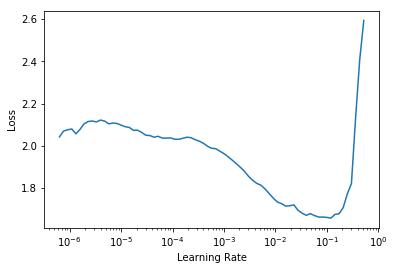

In [78]:
learn.recorder.plot()

In [79]:
lr = 5e-3

In [80]:
learn.fit_one_cycle(12, max_lr=lr)

Total time: 04:59
epoch  train_loss  valid_loss  accuracy
1      1.113853    0.806195    0.695592  (00:23)
2      0.920623    0.680211    0.747934  (00:24)
3      0.791692    0.784804    0.688705  (00:25)
4      0.773110    0.682950    0.720386  (00:24)
5      0.722028    0.635494    0.727273  (00:25)
6      0.675507    0.579877    0.752066  (00:25)
7      0.651792    0.666858    0.752066  (00:24)
8      0.617585    0.509250    0.793388  (00:25)
9      0.574291    0.498136    0.812672  (00:26)
10     0.568673    0.481214    0.818182  (00:24)
11     0.566743    0.479276    0.814050  (00:24)
12     0.544410    0.478495    0.804408  (00:24)



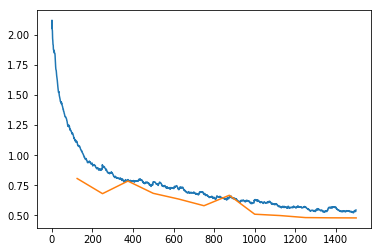

In [81]:
learn.recorder.plot_losses()

In [82]:
learn.save('lung_inf_v2_stage-1_20181101-3')

<font color=blue>**Conclusion stage 1 - Training of new head:**<br>
Training only the the new last layers from the new head (and keeping the rest of the network frozen) enabled the network to achieve a accuracy of approx. 0.81 (81%) after 12 epochs. This is already equal to the published accuracy benchmark!

### Stage 2 - Training of the entire network

In stage 2 the entire network is trained with discriminative learning rates, i.e. lower learning rates for the earyl layers and higher learning rates for the late layers.

In [83]:
learn.load('lung_inf_v2_stage-1_20181101-3')

In [84]:
learn.unfreeze()

In [85]:
learn.lr_find()

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


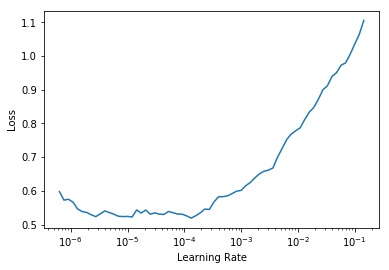

In [64]:
learn.recorder.plot()

In [86]:
learn.fit_one_cycle(1, max_lr=slice(1e-6, lr/10))

Total time: 00:27
epoch  train_loss  valid_loss  accuracy
1      0.537355    0.485425    0.811295  (00:27)



In [87]:
learn.fit_one_cycle(10, max_lr=slice(1e-6, lr/10))

Total time: 04:40
epoch  train_loss  valid_loss  accuracy
1      0.512292    0.481637    0.819559  (00:28)
2      0.529841    0.482626    0.805785  (00:28)
3      0.533183    0.482309    0.820937  (00:28)
4      0.522236    0.479092    0.820937  (00:27)
5      0.513687    0.503302    0.823691  (00:28)
6      0.517527    0.483693    0.816804  (00:27)
7      0.522619    0.495015    0.809917  (00:27)
8      0.481072    0.479794    0.818182  (00:27)
9      0.490501    0.477336    0.819559  (00:27)
10     0.451912    0.493569    0.822314  (00:27)



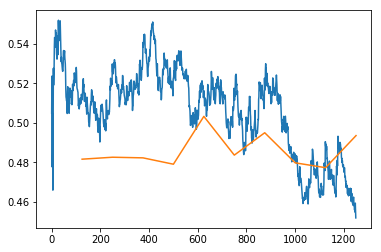

In [88]:
learn.recorder.plot_losses()

In [89]:
learn.save('lung_inf_v2_stage-2_20181101-3')

In [107]:
learn.load('lung_inf_v2_stage-2_20181101-3')

<font color=blue>**Conclusion stage 2 - Training of the entire network:**<br>
The training of the entire network with discriminative learning rates was able to reduce the training loss and increase the accuracy slightly.

## Setup data and model (stage 3)

### Data setup

In [4]:
# set batchsize and image size for network
bs = 32//4 # floor divided by 4 to make up for the image increas of apprx. 4x more pixels
size = 512

In [5]:
tfms = get_transforms(do_flip=True, flip_vert=True, max_rotate=90, max_zoom=1.1, max_lighting=0.1, max_warp=0.2)

In [6]:
# setup data with fastai data block API (https://docs.fast.ai/data_block.html)
data = (ImageFileList.from_folder(path/'lung_inflammation', extensions='.png')\
        .label_from_folder() # get labels from folders\
        .split_by_folder() # split dataset by train/valid folders\
        .datasets(ImageClassificationDataset) # creat image classification dataset\
        .transform(tfms, size=size) # apply transformations and resize images\
        .databunch(bs=bs)) # creat databunch with bs

In [7]:
# normaliez data with ImagNet statistics
data.normalize(imagenet_stats);

### Model setup

In [8]:
!gpustat

psbtmxtmo  Thu Nov  1 10:53:59 2018
[0] Quadro P4000     | 60'C,   0 % |    10 /  8119 MB |


In [9]:
learn = create_cnn(data, models.resnet34, metrics=accuracy)

In [10]:
learn.load('lung_inf_v2_stage-2_20181101-3')

In [11]:
learn.unfreeze()

In [12]:
!gpustat

psbtmxtmo  Thu Nov  1 10:54:04 2018
[0] Quadro P4000     | 58'C,   7 % |   701 /  8119 MB | paperspace(691M)


## Training (stage 3)

### Stage 3 - Increased image size

In [13]:
learn.lr_find()

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


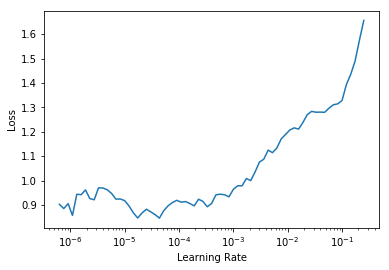

In [14]:
learn.recorder.plot()

In [15]:
lr = 1e-4

In [16]:
learn.fit_one_cycle(3, max_lr=lr)

Total time: 06:01
epoch  train_loss  valid_loss  accuracy
1      0.843632    1.131773    0.668044  (01:59)
2      0.764814    0.534714    0.794766  (02:03)
3      0.616686    0.522066    0.801653  (01:58)



In [17]:
learn.fit_one_cycle(3, max_lr=lr)

Total time: 05:53
epoch  train_loss  valid_loss  accuracy
1      0.728162    0.753725    0.716253  (01:57)
2      0.694195    0.589637    0.769972  (01:58)
3      0.610053    0.495766    0.818182  (01:58)



In [18]:
learn.save('lung_inf_v2_stage-3_20181101-3a')

In [19]:
learn.load('lung_inf_v2_stage-3_20181101-3a')

In [20]:
learn.fit_one_cycle(3, max_lr=lr)

Total time: 05:53
epoch  train_loss  valid_loss  accuracy
1      0.767008    0.542189    0.800275  (01:56)
2      0.678056    0.520460    0.805785  (01:57)
3      0.629956    0.481514    0.827824  (01:58)



In [21]:
learn.save('lung_inf_v2_stage-3_20181101-3b')

In [22]:
learn.load('lung_inf_v2_stage-3_20181101-3b')

In [23]:
learn.lr_find()

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


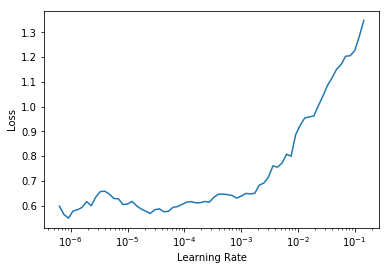

In [24]:
learn.recorder.plot()

In [25]:
lr = 1e-5

In [26]:
learn.fit_one_cycle(3, max_lr=lr)

Total time: 05:53
epoch  train_loss  valid_loss  accuracy
1      0.633723    0.489298    0.826446  (01:57)
2      0.622087    0.478166    0.827824  (01:58)
3      0.573432    0.496157    0.818182  (01:58)



In [27]:
learn.save('lung_inf_v2_stage-3_20181101-3c')

In [28]:
learn.load('lung_inf_v2_stage-3_20181101-3c')

In [29]:
learn.fit_one_cycle(3, max_lr=lr)

Total time: 05:55
epoch  train_loss  valid_loss  accuracy
1      0.572503    0.513777    0.811295  (01:58)
2      0.566018    0.479018    0.829201  (01:58)
3      0.561713    0.480384    0.825069  (01:58)



In [30]:
learn.save('lung_inf_v2_stage-3_20181101-3d')

In [31]:
learn.load('lung_inf_v2_stage-3_20181101-3d')

## Interpretation

In [108]:
interp = ClassificationInterpretation.from_learner(learn)

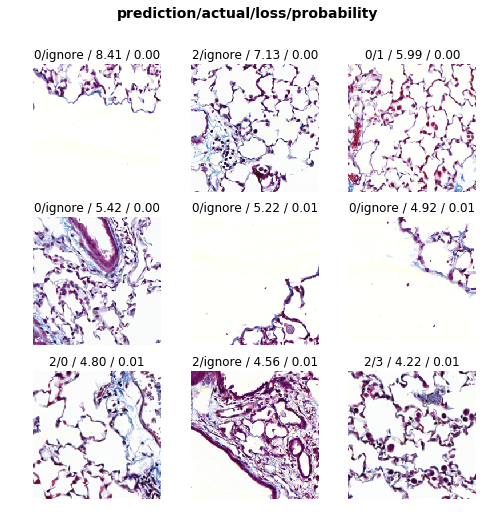

In [112]:
interp.plot_top_losses(9, figsize=(8,8))

In [113]:
interp.confusion_matrix()

array([[250,   2,   0,   6,  18],
       [  1,  44,   7,   1,  22],
       [  1,   8,  58,   2,   1],
       [ 17,   5,   3, 169,   2],
       [ 22,  10,   1,   0,  76]])

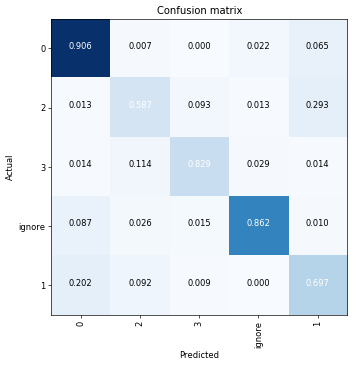

In [124]:
interp.plot_confusion_matrix(figsize=(6,6), dpi=60, normalize=True)

## Work in progress

In [40]:
from fastai.widgets import *

In [41]:
losses, idx = interp.top_losses()

In [45]:
top_loss_path = data.valid_ds.x[idx]

In [67]:
fd = FileDeleter(file_paths=top_loss_path)